# 머신러닝 모델 기반 다른 유저들의 승률 예측 분석

<목차>

1. 개요

2. EDA

3. Feature Engineering

4. 모델 개발

5. 모델 평가

---
---

## 개요

### 1. 목적
- 승리 예측 모델 개발 및 특성 중요도 분석
    - 승리에 주요하게 영향을 미치는 특성을 파악하기 위함

### 2. 데이터 설명
- FC온라인 API를 통해 수집한 다른 유저들의 경기 데이터
- 득점한 선수에 관련한 데이터는 분석에 활용하지 않고, 유저의 플레이 데이터만 활용한다.
- 매치ID 중복 데이터 존재 > 경기 기준이 아닌 골 기준으로 ROW가 집계됨(득점 좌표 데이터 활용하기 위함)
- API를 통해 호출한 데이터를 가공하여 다운 받은 CSV 파일을 호출한다.

### 3. 분석 환경 조성

#### ㄴ 라이브러리 호출

In [35]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import plotly.express as px


from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

#### ㄴ 데이터 호출

In [36]:
# 데이터 프레임 생성
#match_df_1 = pd.read_csv('250321_recent_matches.csv', encoding='utf-8-sig')
#match_df_2 = pd.read_csv('250323_recent_matches.csv', encoding='utf-8-sig')
match_df_3 = pd.read_csv('250324_recent_matches.csv', encoding='utf-8-sig')

In [37]:
# 각 데이터 프레임 크기 확인
#print(match_df_1.shape) # 3/21기준 최근 100경기 데이터
#print(match_df_2.shape) # 3/23기준 최근 100경기 데이터
print(match_df_3.shape) # 3/24기준 최근 100경기 데이터

(86, 43)


In [ ]:
# 데이터 프레임 확인
match_df_1.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e13ae44065376a668ffd79,2025-03-24T10:59:34,50,c69d1fc3d30168bae289e407f866e913,DRX엄지렐라,패,2,0,0,0,...,127,0.950309,0.483909,6,1,291206594,False,-1,False,True
1,67e13aa29ed34d74ce8f1afa,2025-03-24T10:59:57,50,a4c86fd92dbadafe4acef48dc03579ea,소각영도점,패,2,0,0,0,...,425,0.880318,0.622680,2,2,265216409,False,-1,False,True
2,67e13a8aa1826dbfeede1857,2025-03-24T10:58:33,50,c1985d83d9eaf2451042c6d93e566b14,너없이는못살아,승,1,0,0,0,...,490,0.827593,0.522800,2,3,289049072,True,814166149,False,False
3,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,575,0.941004,0.672179,1,3,829231447,True,252214100,False,True
4,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,154,0.890730,0.583691,2,3,268192181,True,252214100,False,True


In [4]:
# 데이터 프레임 확인
match_df_2.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,possession,averageRating,dribble,cornerKick,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67dfdb2cffc7b2223341cf28,2025-03-23T09:59:42,50,11e680208c9d26a251023337fcf4e870,망고욱현,승,62,4.38333,4,0,...,232,0.906021,0.670537,2,3,291240452,True,829227232,False,True
1,67dfdb1a8a1ee8788f3e6130,2025-03-23T09:59:03,50,5403c8a5423a2c08696f68a32bc816c6,찌랭이0327,승,44,3.98889,5,1,...,573,0.839968,0.387843,2,3,832256630,True,291240709,False,False
2,67dfdb17e795d740a68bdf08,2025-03-23T09:59:50,50,7e09a42b042a3ca88ba0d8214c61fc79,구단주댄스바,패,48,3.49444,7,1,...,475,0.783291,0.395553,4,2,826225539,False,-1,False,False
3,67dfdb17e795d740a68bdf08,2025-03-23T09:59:50,50,7e09a42b042a3ca88ba0d8214c61fc79,구단주댄스바,패,48,3.49444,7,1,...,135,0.908727,0.547382,1,1,826225539,True,270243702,False,True
4,67dfdaea8f28057e623fbaf9,2025-03-23T09:58:53,50,62ce1ea7553b9306f327702dfeaa0ba9,JEON영진,패,60,3.71111,10,0,...,490,0.928970,0.413836,6,1,832194765,True,825028130,False,True


In [39]:
# 데이터 프레임 확인
match_df_3.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e13ae44065376a668ffd79,2025-03-24T10:59:34,50,c69d1fc3d30168bae289e407f866e913,DRX엄지렐라,패,2,0,0,0,...,127,0.950309,0.483909,6,1,291206594,False,-1,False,True
1,67e13aa29ed34d74ce8f1afa,2025-03-24T10:59:57,50,a4c86fd92dbadafe4acef48dc03579ea,소각영도점,패,2,0,0,0,...,425,0.880318,0.622680,2,2,265216409,False,-1,False,True
2,67e13a8aa1826dbfeede1857,2025-03-24T10:58:33,50,c1985d83d9eaf2451042c6d93e566b14,너없이는못살아,승,1,0,0,0,...,490,0.827593,0.522800,2,3,289049072,True,814166149,False,False
3,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,575,0.941004,0.672179,1,3,829231447,True,252214100,False,True
4,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,154,0.890730,0.583691,2,3,268192181,True,252214100,False,True


- 두 데이터 프레임 병합
    - 각 날짜에 최근 100경기를 API로 호출했으나 몇 경기에서 error 코드가 발생해 집계가 되지 않는 문제 발생
    - 최대한 많은 모수 확보를 위해 해당 데이터 제외하고 나머지 데이터들 호출

In [40]:
# 데이터 병합
# match_df = pd.concat([match_df_1,match_df_2,match_df_3], axis=0, ignore_index=True)
match_df = match_df_3
match_df.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e13ae44065376a668ffd79,2025-03-24T10:59:34,50,c69d1fc3d30168bae289e407f866e913,DRX엄지렐라,패,2,0,0,0,...,127,0.950309,0.483909,6,1,291206594,False,-1,False,True
1,67e13aa29ed34d74ce8f1afa,2025-03-24T10:59:57,50,a4c86fd92dbadafe4acef48dc03579ea,소각영도점,패,2,0,0,0,...,425,0.880318,0.622680,2,2,265216409,False,-1,False,True
2,67e13a8aa1826dbfeede1857,2025-03-24T10:58:33,50,c1985d83d9eaf2451042c6d93e566b14,너없이는못살아,승,1,0,0,0,...,490,0.827593,0.522800,2,3,289049072,True,814166149,False,False
3,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,575,0.941004,0.672179,1,3,829231447,True,252214100,False,True
4,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,154,0.890730,0.583691,2,3,268192181,True,252214100,False,True


---

## EDA

### 1. 데이터 확인

In [41]:
# 데이터 크기 확인
match_df.shape

(86, 43)

In [42]:
# 기술 통계 분석
match_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
matchId,86,26,67e139c70bba2623f0c903e4,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchDate,86,24,2025-03-24T10:58:57,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchType,86.0,NaN,NaN,NaN,50.0,0.0,50.0,50.0,50.0,50.0,50.0
ouid,86,30,ebad709ed2c3751a39fa468c027a7956,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nickname,86,30,닉넴안씀,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchResult,86,2,승,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchEndType,86.0,NaN,NaN,NaN,1.209302,0.409197,1.0,1.0,1.0,1.0,2.0
foul,86.0,NaN,NaN,NaN,0.22093,0.470323,0.0,0.0,0.0,0.0,2.0
injury,86.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
redCards,86.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# 데이터 정보 확인
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   matchId              86 non-null     object 
 1   matchDate            86 non-null     object 
 2   matchType            86 non-null     int64  
 3   ouid                 86 non-null     object 
 4   nickname             86 non-null     object 
 5   matchResult          86 non-null     object 
 6   matchEndType         86 non-null     int64  
 7   foul                 86 non-null     int64  
 8   injury               86 non-null     int64  
 9   redCards             86 non-null     int64  
 10  yellowCards          86 non-null     int64  
 11  possession           86 non-null     int64  
 12  averageRating        86 non-null     float64
 13  dribble              86 non-null     int64  
 14  cornerKick           86 non-null     int64  
 15  offsideCount         86 non-null     int64

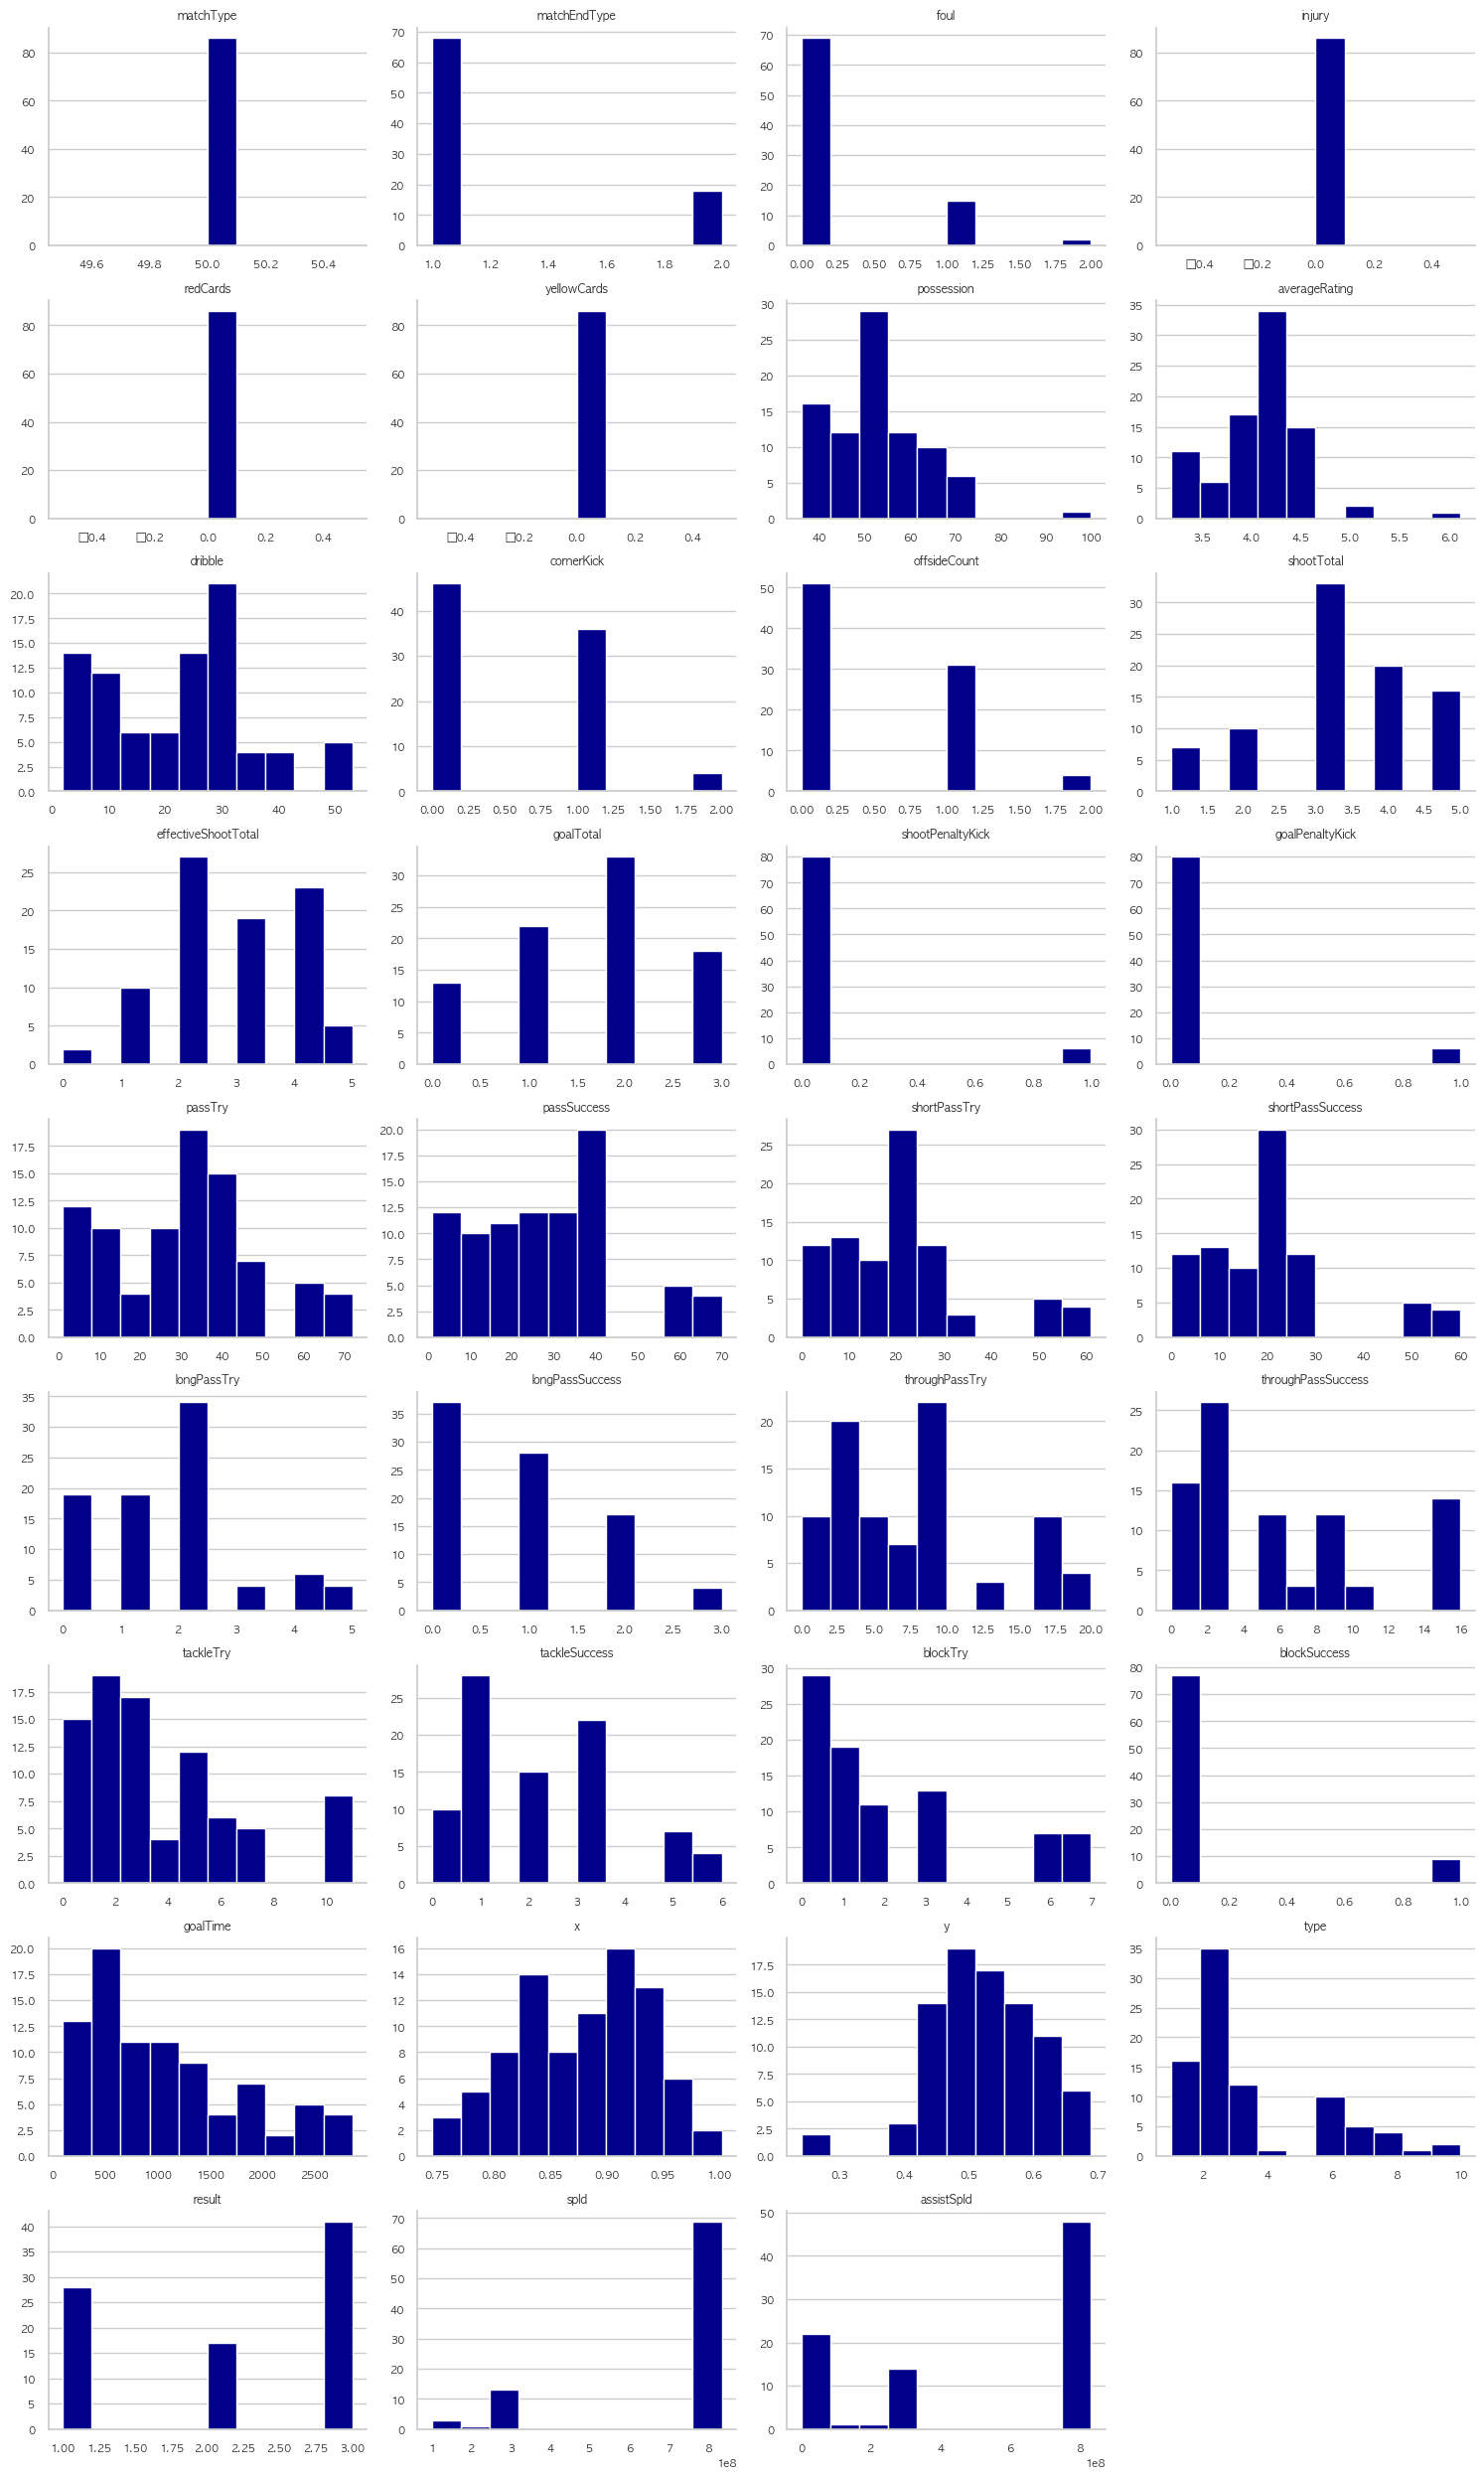

In [45]:
# 데이터 분포 시각화
# 변수 선별
numeric_df = match_df.select_dtypes(include=['number'])
cols = numeric_df.columns

# 서브플롯 생성
fig, axes = plt.subplots(9, 4, figsize=(15, 25))
axes = axes.flatten()

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    axes[i].hist(numeric_df[column].dropna(), color='darkblue', alpha=1)
    axes[i].set_title(column)
    axes[i].grid(axis='x', linestyle=':', color='darkgrey')
    axes[i].grid(axis='x')
    axes[i].spines[['top','right']].set_visible(False)

# 빈 서브플롯 숨기기
for j in range(len(cols), len(axes)):
    axes[j].axis("off")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

> 결론
- spId, assistSpId는 선수 고유 ID
- goalTime의 max값이 3분위수와 차이가 많이 난다.
- 연속형 변수 중, goalTime을 제외하고는 특별한 이상치가 기술 통계량에서는 확인되지 않는다.
- matchResult는 승리 여부로, 범주형 변수이자 머신러닝 모델의 종속변수가 된다.(이진수가 아닌 '승','패'로 object 타입으로 저장되어 있다.)
- Try와 Success 데이터를 통해 성공확률을 도출할 수 있다.(ex. 패스, 숏패스, 롱패스, 스루패스, 태클 등)

### 2. 데이터 전처리

#### ㄴ 결측값 처리

In [46]:
# 결측값 확인
match_df.isna().sum()

matchId                0
matchDate              0
matchType              0
ouid                   0
nickname               0
matchResult            0
matchEndType           0
foul                   0
injury                 0
redCards               0
yellowCards            0
possession             0
averageRating          0
dribble                0
cornerKick             0
offsideCount           0
shootTotal             0
effectiveShootTotal    0
goalTotal              0
shootPenaltyKick       0
goalPenaltyKick        0
passTry                0
passSuccess            0
shortPassTry           0
shortPassSuccess       0
longPassTry            0
longPassSuccess        0
throughPassTry         0
throughPassSuccess     0
tackleTry              0
tackleSuccess          0
blockTry               0
blockSuccess           0
goalTime               0
x                      0
y                      0
type                   0
result                 0
spId                   0
assist                 0


#### ㄴ 중복값 처리

- 데이터는 골 기준으로 ROW가 생성되고 있다.
- 한 경기에 여러 골이 발생하므로 matchId는 중복값 발생
- 따라서 식별자로 사용할 수 없으므로 모든 행에 대해서 중복값이 있는지 체크한다.

In [47]:
# 중복값 확인
match_df.duplicated().sum()

np.int64(0)

#### ㄴ 이상치 처리

In [58]:
# 몰수승, 몰수패는 정상적으로 종료되지 않은 매치이므로 제외한다.('matchEndType' == 0인 경우가 정상)
preprocessed_df = match_df.copy()
preprocessed_df['matchEndType'].unique()

array([2, 1])

In [ ]:
# 정상종료 매치만 남기기
preprocessed_df = preprocessed_df[preprocessed_df['matchEndType'] == 0]

In [59]:
# 수치형 변수 확인
numeric_df.columns

Index(['matchType', 'matchEndType', 'foul', 'injury', 'redCards',
       'yellowCards', 'possession', 'averageRating', 'dribble', 'cornerKick',
       'offsideCount', 'shootTotal', 'effectiveShootTotal', 'goalTotal',
       'shootPenaltyKick', 'goalPenaltyKick', 'passTry', 'passSuccess',
       'shortPassTry', 'shortPassSuccess', 'longPassTry', 'longPassSuccess',
       'throughPassTry', 'throughPassSuccess', 'tackleTry', 'tackleSuccess',
       'blockTry', 'blockSuccess', 'goalTime', 'x', 'y', 'type', 'result',
       'spId', 'assistSpId'],
      dtype='object')

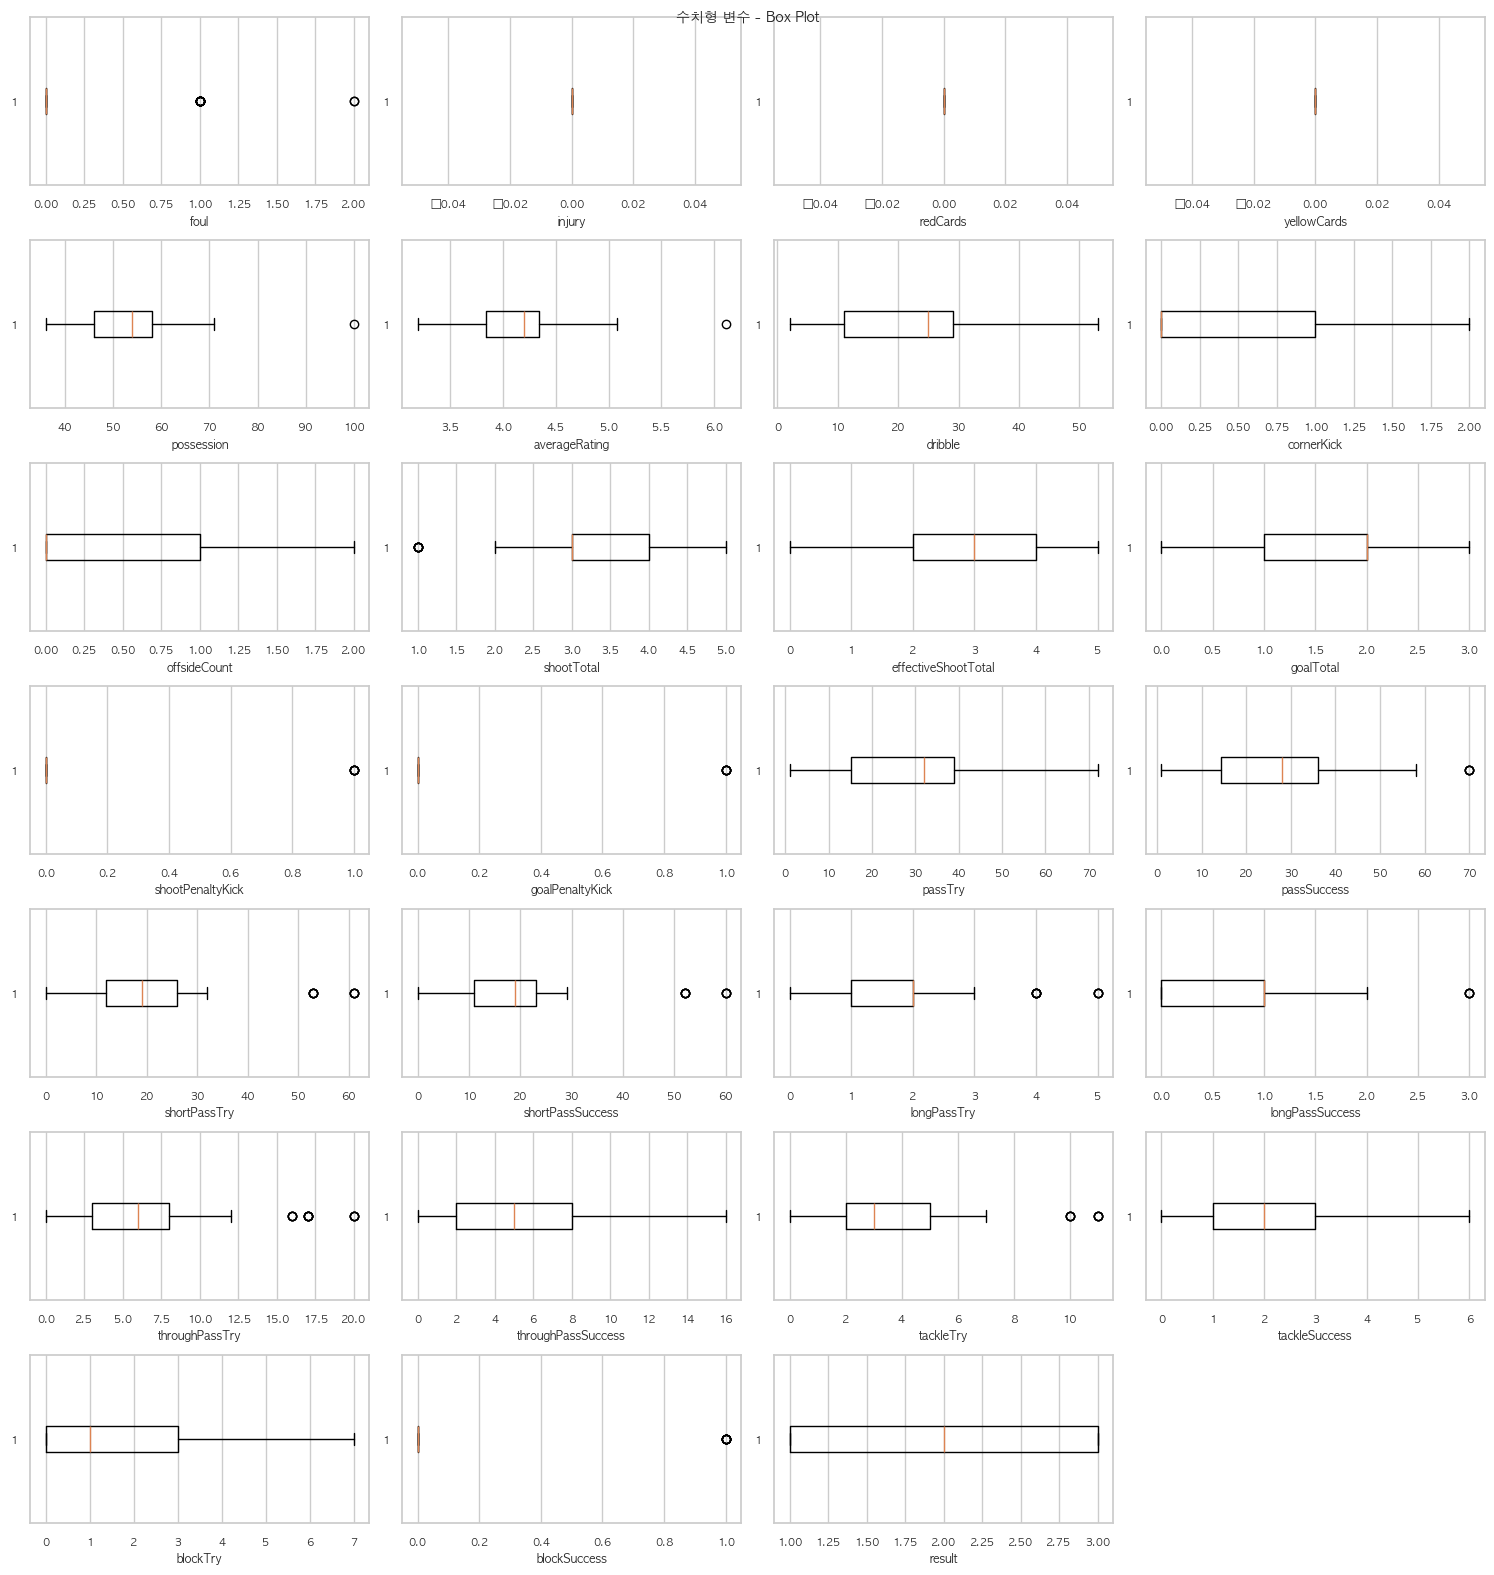

In [ ]:
# 이상치 확인할 변수 선택
outlier_cols = list(numeric_df.drop(columns=['matchType', 'matchEndType','goalTime','x', 'y', 'type','spId', 'assistSpId']).columns)

# 컬럼별 이상치 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(10,6)}, font_scale=0.7, font='AppleGothic')

fig, axes = plt.subplots(7,4,figsize=(15, 16))
axes = axes.flatten()

for i, col in enumerate(outlier_cols):
    axes[i].boxplot(preprocessed_df[col],  vert=False)
    axes[i].set_xlabel(f'{col}')
    axes[i].set_xlabel(f'{col}')
    axes[i].grid(axis='y')

# 빈 서브플롯 숨기기
for j in range(len(outlier_cols), len(axes)):
    axes[j].axis("off")

fig.suptitle('수치형 변수 - Box Plot')

fig.tight_layout()
fig.show()

In [62]:
# 이상치 개수 확인
for col in outlier_cols:
  q1 = preprocessed_df[col].quantile(0.25)
  q3 = preprocessed_df[col].quantile(0.75)
  iqr = q3-q1
  outlier_count = len(preprocessed_df[(preprocessed_df[col] < (q1 - (1.5*iqr)))|(preprocessed_df[col] > (q3 + (1.5*iqr)))])

  print(f"{col} - 이상치 개수: {outlier_count}", '/', f"비율: {round((outlier_count/len(preprocessed_df))*100,2)}%")

foul - 이상치 개수: 17 / 비율: 19.77%
injury - 이상치 개수: 0 / 비율: 0.0%
redCards - 이상치 개수: 0 / 비율: 0.0%
yellowCards - 이상치 개수: 0 / 비율: 0.0%
possession - 이상치 개수: 1 / 비율: 1.16%
averageRating - 이상치 개수: 1 / 비율: 1.16%
dribble - 이상치 개수: 0 / 비율: 0.0%
cornerKick - 이상치 개수: 0 / 비율: 0.0%
offsideCount - 이상치 개수: 0 / 비율: 0.0%
shootTotal - 이상치 개수: 7 / 비율: 8.14%
effectiveShootTotal - 이상치 개수: 0 / 비율: 0.0%
goalTotal - 이상치 개수: 0 / 비율: 0.0%
shootPenaltyKick - 이상치 개수: 6 / 비율: 6.98%
goalPenaltyKick - 이상치 개수: 6 / 비율: 6.98%
passTry - 이상치 개수: 0 / 비율: 0.0%
passSuccess - 이상치 개수: 4 / 비율: 4.65%
shortPassTry - 이상치 개수: 9 / 비율: 10.47%
shortPassSuccess - 이상치 개수: 9 / 비율: 10.47%
longPassTry - 이상치 개수: 10 / 비율: 11.63%
longPassSuccess - 이상치 개수: 4 / 비율: 4.65%
throughPassTry - 이상치 개수: 14 / 비율: 16.28%
throughPassSuccess - 이상치 개수: 0 / 비율: 0.0%
tackleTry - 이상치 개수: 8 / 비율: 9.3%
tackleSuccess - 이상치 개수: 0 / 비율: 0.0%
blockTry - 이상치 개수: 0 / 비율: 0.0%
blockSuccess - 이상치 개수: 9 / 비율: 10.47%
result - 이상치 개수: 0 / 비율: 0.0%


> 결론

- foul : 파울 수이므로 대부분의 데이터가 0에 몰려 있어 사분위수로 이상치 탐지시 1, 2와 같은 정상값도 이상치로 간주됨.(이상치 처리 X)
- possession : 점유율이 100%인 경우는 존재할 수 없으므로 이상치로 간주하여 처리한다.
- averageRating : 경기 사후에 매겨지는 경기 평점이므로 경기 결과에 영향을 주지 않는다. 이상치 처리 필요성 X
- shootTotal : 총 슈팅 수가 1인 경기 또한 공격이 제대로 진행되지 않은 경기로써, 분석할 가치가 있으므로 이상치 처리 X
- shootPenaltyKick : 대부분의 경기에서 페널티킥이 발생하지 않으므로 1이 이상치로 관찰되는 것이며, 실질적인 이상치는 아니다.
- goalPenaltyKick : 위와 동일
- passSuccess : 

In [61]:
outlier_cols

['foul',
 'injury',
 'redCards',
 'yellowCards',
 'possession',
 'averageRating',
 'dribble',
 'cornerKick',
 'offsideCount',
 'shootTotal',
 'effectiveShootTotal',
 'goalTotal',
 'shootPenaltyKick',
 'goalPenaltyKick',
 'passTry',
 'passSuccess',
 'shortPassTry',
 'shortPassSuccess',
 'longPassTry',
 'longPassSuccess',
 'throughPassTry',
 'throughPassSuccess',
 'tackleTry',
 'tackleSuccess',
 'blockTry',
 'blockSuccess',
 'result']

#### ㄴ 데이터 인코딩